# Stochastic Model 03: Algoritmus MCMC (Přímé vzorkování)

In [1]:
# Instalace potřebných knihoven
#%pip install pandas
#%pip install numpy
#%pip install seaborn matplotlib

In [2]:
# Import potřebných knihoven
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Načtení přechodové matice

In [3]:
# Soubor je načten a přiřazen do proměnné ‚df‘
other_path = '../../data/03_StochModel/transition_matrix.csv'
df = pd.read_csv(other_path, header=0)
P = df.to_numpy()

### Parametry simulace

In [4]:
n_states = 12

dt = 1                           # sekunda

# počet iteračních kroků (sekund)
simulation_time = 2_000_000      # délka simulace

# Doby setrvání (s)
T = {
    "S1": 2, "S2": 2, "S3": 5, "S4": 2,
    "S5": 5, "S6": 7, "S7": 3, "S8": 6,
    "S9": 60, "S10": 70, "S11": 160, "S12": 20
}

# Stav
T_S = {
    "S1": 1, "S2": 2, "S3": 3, "S4": 4,
    "S5": 5, "S6": 6, "S7": 7, "S8": 8,
    "S9": 9, "S10": 10, "S11": 11, "S12": 12
}

# Intenzity poruch (1/s)
lambda_vals = {
    "S9": 4/8896,
    "S10": 7/8896,
    "S11": 3/8896,
    "S12": 13/8896
}

# nastavení seedu (počátečního stavu generátoru náhodných čísel)
rng = np.random.default_rng(seed=1122)

# Sekvence provozních stavů
operational_sequence = ["S1","S2","S3","S4","S5","S6","S7","S8"]

# Návraty z poruch
returns = {
    "S9": "S1",
    "S10": "S3",
    "S11": "S1",
    "S12": "S5"
}

burn_in = 100_000

### Nastavení počátečního stavu

In [5]:
# počáteční stav S1 (index 0)

current_state = "S1"
time_in_state = 0

state_time_counter = {s:0 for s in T.keys()}
state_time_counter_burn_in = {s:0 for s in T.keys()}

### Generování stochastických vzorků pomocí metody MCMC

In [6]:
state_history = []
samples = []

for t in range(simulation_time):

    if t > burn_in:
        state_time_counter_burn_in[current_state] += dt
    state_time_counter[current_state] += dt
    time_in_state += dt

    # ===== PROVOZNÍ STAVY =====
    if current_state in operational_sequence:

        # 1️ Kontrola poruch
        fault_triggered = False

        for fault_state, lam in lambda_vals.items():
            if rng.random() < lam * dt:
                current_state = fault_state
                time_in_state = 0
                fault_triggered = True
                break

        if fault_triggered:
            continue

        # 2️ Kontrola dokončení provozního stavu
        if time_in_state >= T[current_state]:

            idx = operational_sequence.index(current_state)
            next_idx = (idx + 1) % len(operational_sequence)
            current_state = operational_sequence[next_idx]
            time_in_state = 0

    # ===== PORUCHOVÉ STAVY =====
    else:

        if time_in_state >= T[current_state]:
            current_state = returns[current_state]
            time_in_state = 0

    state_history.append(T_S[current_state])
    samples.append(T_S[current_state])

### Výpočet empirického stacionárního rozdělení

In [7]:
# Výpočet empirického stacionárního rozdělení π ze simulace
# jako podílu času stráveného v jednotlivých stavech
total_time = sum(state_time_counter.values())
pi_sim = np.array([state_time_counter[s]/total_time for s in T.keys()])

print("Stacionární rozdělení ze simulace:")

cycle_times = np.round(pi_sim, 8)
cycle_times

Stacionární rozdělení ze simulace:


array([0.0533695, 0.05306  , 0.1346495, 0.0532855, 0.138159 , 0.189942 ,
       0.080186 , 0.1581135, 0.02253  , 0.047845 , 0.04376  , 0.0251   ])

### Sloupcový density graf

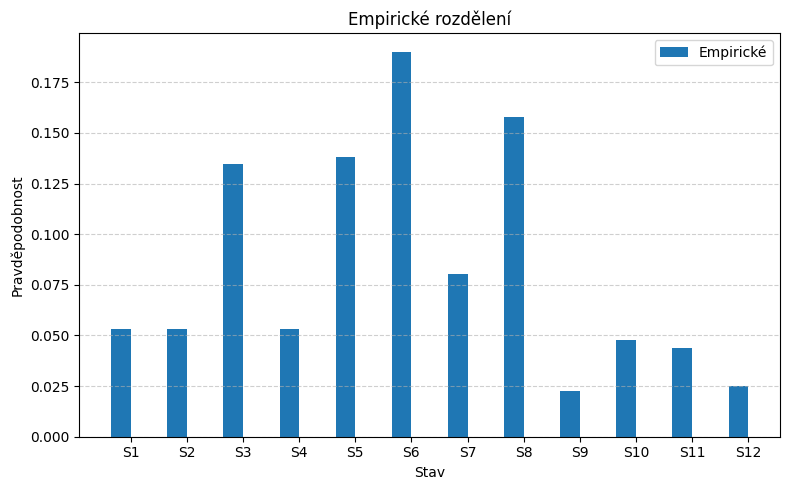

In [8]:
width = 0.35

states = np.arange(1,13)
states = np.arange(1,13)
state_labels = [f"S{i}" for i in states]

plt.figure(figsize=(8,5))

plt.bar(states - width/2, cycle_times, width, label='Empirické')

# --- osa X pro každý stav ---
plt.xticks(states, state_labels)

plt.xlabel("Stav")
plt.ylabel("Pravděpodobnost")
plt.title("Empirické rozdělení")

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Ilustrační graf simulace

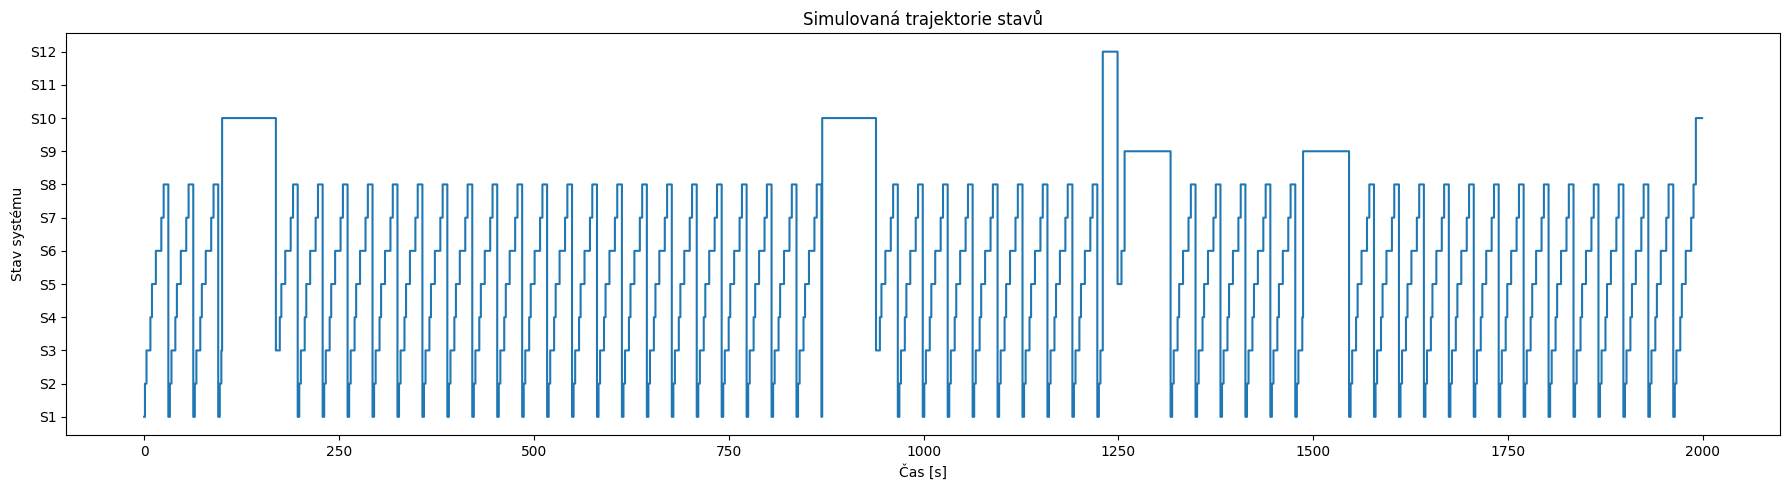

In [9]:
N = 2_000

# pořadí stavů
states = ["S1","S2","S3","S4","S5","S6",
          "S7","S8","S9","S10","S11","S12"]

# převod stavů na čísla 0–11
numeric_trajectory = [s-1 for s in state_history]

# časová osa (např. prvních N s pro přehlednost)
time_window = N
t = np.arange(time_window)

plt.figure(figsize=(18,5))
plt.step(t, numeric_trajectory[:time_window], where="post")

plt.yticks(range(len(states)), states)
plt.xlabel("Čas [s]")
plt.ylabel("Stav systému")
plt.title("Simulovaná trajektorie stavů")
plt.tight_layout()
plt.show()

### Simulovaná dostupnost systému (prvních 1 000 000 kroků)

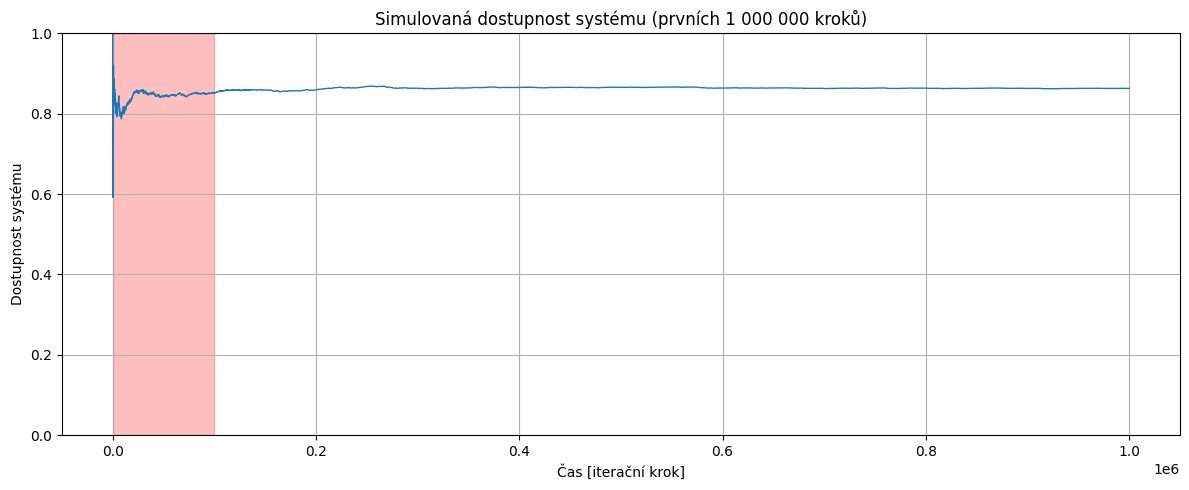

In [10]:
N = 1_000_000

# ===== Indikátor provozu =====
# S1–S8 jsou provozní stavy (index 1–8)
samples = np.array(samples)
operational = (samples < 9).astype(int)

# ===== Běžící dostupnost =====
availability_running = np.cumsum(operational[:N]) / np.arange(1, N+1)

# ===== Graf =====
plt.figure(figsize=(12,5))
plt.plot(availability_running, linewidth=1)

plt.axvspan(0, burn_in, color='red', alpha=0.25)

plt.xlabel("Čas [iterační krok]")
plt.ylabel("Dostupnost systému")
plt.title("Simulovaná dostupnost systému (prvních 1 000 000 kroků)")

plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

### Výpočet empirického stacionárního rozdělení po Burn-in

In [11]:
# Výpočet empirického stacionárního rozdělení π ze simulace po Burn-in
# jako podílu času stráveného v jednotlivých stavech
total_time = sum(state_time_counter_burn_in.values())
pi_sim = np.array([state_time_counter_burn_in[s]/total_time for s in T.keys()])

print("Stacionární rozdělení ze simulace po Burn_in:")

cycle_times = np.round(pi_sim, 8)
cycle_times

Stacionární rozdělení ze simulace po Burn_in:


array([0.05340371, 0.05308898, 0.13469849, 0.05331055, 0.13826586,
       0.19008747, 0.08025636, 0.1582464 , 0.0225158 , 0.04752634,
       0.04336844, 0.02523159])

### Export simulace formátu CSV

In [12]:
df_sim = pd.DataFrame({
    "time": np.arange(len(samples[burn_in:burn_in+1_000_000])),
    "state_index": samples[burn_in:burn_in+1_000_000],
})

In [13]:
df_sim

,time,state_index
0,0,7
1,1,7
2,2,7
3,3,8
4,4,8
...,...,...
999995,999995,6
999996,999996,6
999997,999997,6
999998,999998,7


In [14]:
df_sim.to_csv('../../data/03_StochModel/simulation_MCMC_samples.csv', index=False)

### Autor / Organizace / Datum

Vjačeslav Usmanov, ČVUT v Praze, Fakulta stavební

###### Přehled změn


|  Datum (YYYY-MM-DD) |  Verze | Autor změny  |  Popis změny |
|---|---|---|---|
| 2026-01-25 | 1.1 | Vjačeslav Usmanov| added SM_03_MCMC_samples.ipynb |
| 2026-02-15 | 1.2 | Vjačeslav Usmanov| changed SM_03_MCMC_samples.ipynb |